In [3]:
from pathlib import Path

In [117]:
import geopandas
import matplotlib.pyplot as plt
import numpy

In [4]:
base_path = Path("/mnt/linux-filestore/mistral/thailand-2024-world-bank")

In [10]:
delta = geopandas.read_parquet(base_path / "thailand_floods_trade_flow_delta.gpq")

In [80]:
delta.columns

Index(['from_id', 'to_id', 'from_iso_a3', 'to_iso_a3', 'mode', 'cost_USD_t',
       'geometry', 'nominal_value_kusd', 'nominal_volume_tons',
       'degraded_value_kusd', 'degraded_volume_tons', 'value_kusd',
       'value_kusd_perc', 'value_kusd_factor', 'volume_tons',
       'volume_tons_perc', 'volume_tons_factor'],
      dtype='object')

In [51]:
adm0 = geopandas.read_parquet(base_path / "results/input/admin-boundaries/admin-level-0.geoparquet")[["GID_0", "NAME_0", "geometry"]]

In [33]:
adm1 = geopandas.read_parquet(base_path / "results/input/admin-boundaries/admin-level-1.geoparquet").query("GID_0 == 'THA'")[["GID_1","NAME_1", "geometry"]]
adm2 = geopandas.read_parquet(base_path / "results/input/admin-boundaries/admin-level-2.geoparquet").query("GID_0 == 'THA'")[["GID_2", "NAME_2", "GID_1", "geometry"]]

In [34]:
adm2.head(1)

,GID_2,NAME_2,GID_1,geometry
37478,THA.1.1_1,Chanuman,THA.1_1,"POLYGON ((104.80987 16.00090, 104.80962 16.003..."


In [35]:
delta_adm1 = delta.sjoin(adm1)

In [37]:
delta_adm2 = delta.sjoin(adm2)

In [98]:
delta_adm1_g = geopandas.GeoDataFrame(
    delta_adm1[["value_kusd","value_kusd_perc","value_kusd_factor","volume_tons","volume_tons_perc","volume_tons_factor", "GID_1"]]
    .groupby("GID_1")
    .sum()
    .join(adm1.set_index("GID_1"), how="outer")
    .fillna(0)
)

<Axes: ylabel='Frequency'>

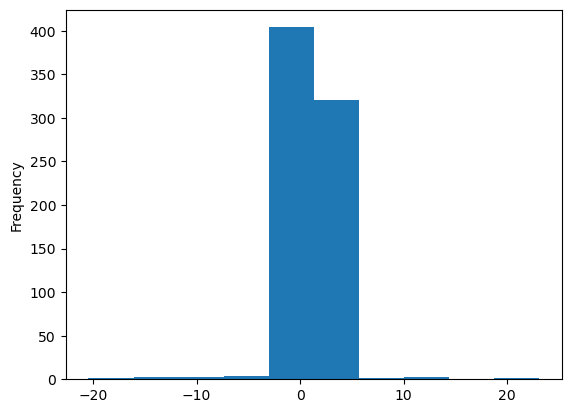

In [115]:
# A ton of trade goods is worth about a thousand dollars
(delta_adm2_g.value_kusd / delta_adm2_g.volume_tons).plot.hist()

In [96]:
delta_adm2_g = geopandas.GeoDataFrame(
    delta_adm2[["value_kusd","value_kusd_perc","value_kusd_factor","volume_tons","volume_tons_perc","volume_tons_factor", "GID_2"]]
    .groupby("GID_2")
    .sum()
    .join(adm2.set_index("GID_2"), how="outer")
    .fillna(0)
)

In [100]:
def get_figure_and_axes():
    f, ax = plt.subplots(figsize=(12, 12))
    ax.set_yticks(range(5, 22))
    ax.set_xticks(range(98, 106))
    ax.grid(alpha=0.1)
    ax.set_xlabel("Longitude [deg]")
    ax.set_ylabel("Latitude [deg]")
    return f, ax

def zoom(ax):
    ax.set_xlim(98, 105)
    ax.set_ylim(12, 19)

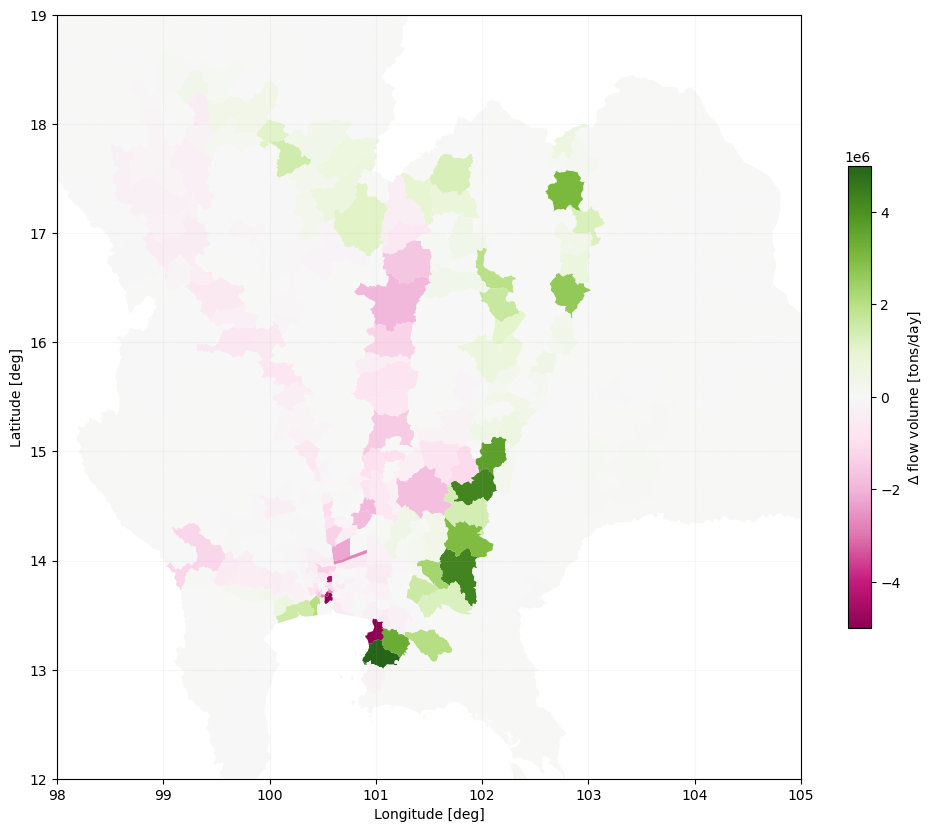

In [101]:
f, ax = get_figure_and_axes()
half_width = 5e6
delta_adm2_g.plot(
    ax=ax,
    column="volume_tons",    
    cmap="PiYG",
    legend=True,
    legend_kwds={"shrink": 0.5, "label": r"$\Delta$ flow volume [tons/day]"},
    vmin=-half_width,
    vmax=half_width,
)
zoom(ax)
f.savefig("adm2_delta_volume.png")

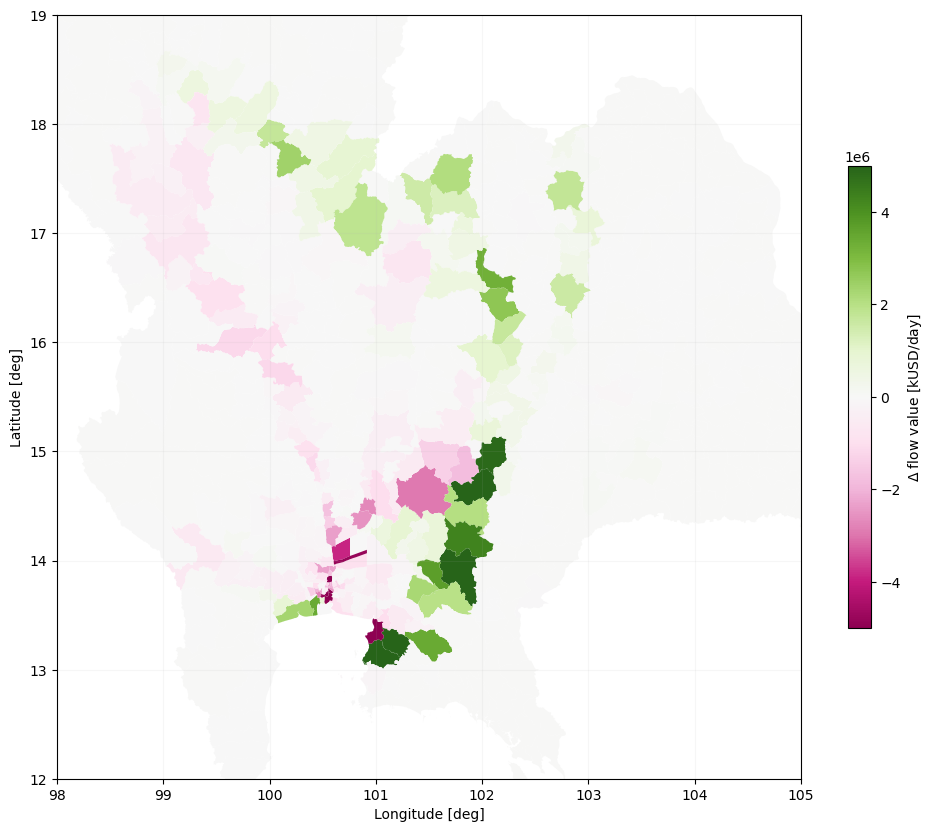

In [107]:
f, ax = get_figure_and_axes()
half_width = 5e6
delta_adm2_g.plot(
    ax=ax,
    column="value_kusd",    
    cmap="PiYG",
    legend=True,
    legend_kwds={"shrink": 0.5, "label": r"$\Delta$ flow value [kUSD/day]"},
    vmin=-half_width,
    vmax=half_width,
)
zoom(ax)
f.savefig("adm2_delta_value.png")

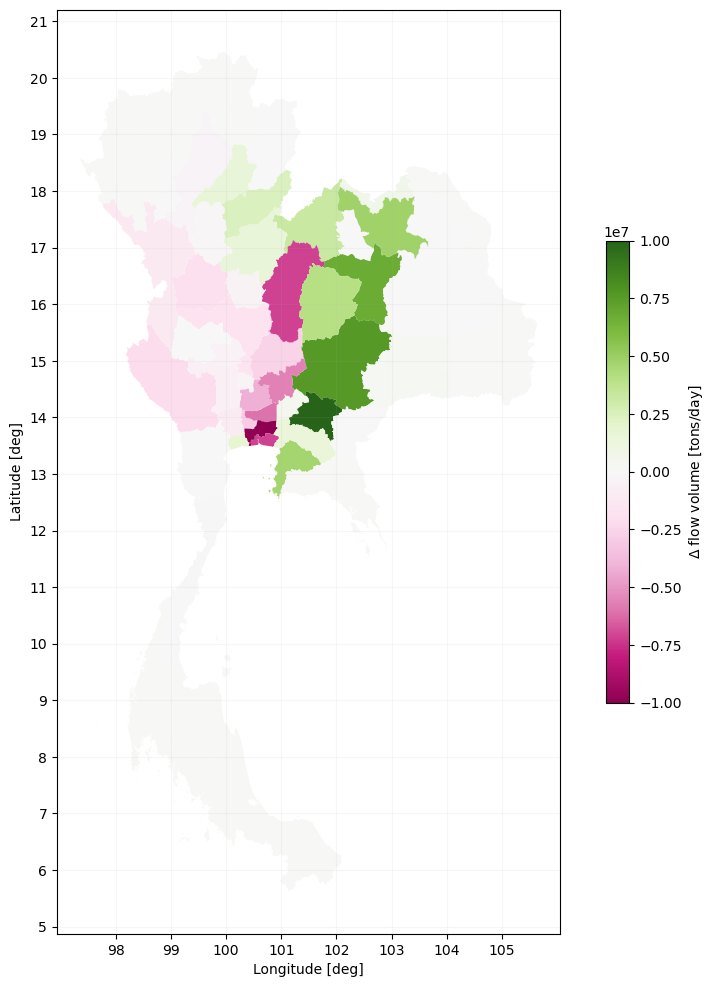

In [109]:
half_width = 1e7
f, ax = get_figure_and_axes()
delta_adm1_g.plot(
    ax=ax,
    column="volume_tons",    
    cmap="PiYG",
    legend=True,
    legend_kwds={"shrink": 0.5, "label": r"$\Delta$ flow volume [tons/day]"},
    vmin=-half_width,
    vmax=half_width,
)
# zoom(ax)
f.savefig("adm1_delta_volume.png")

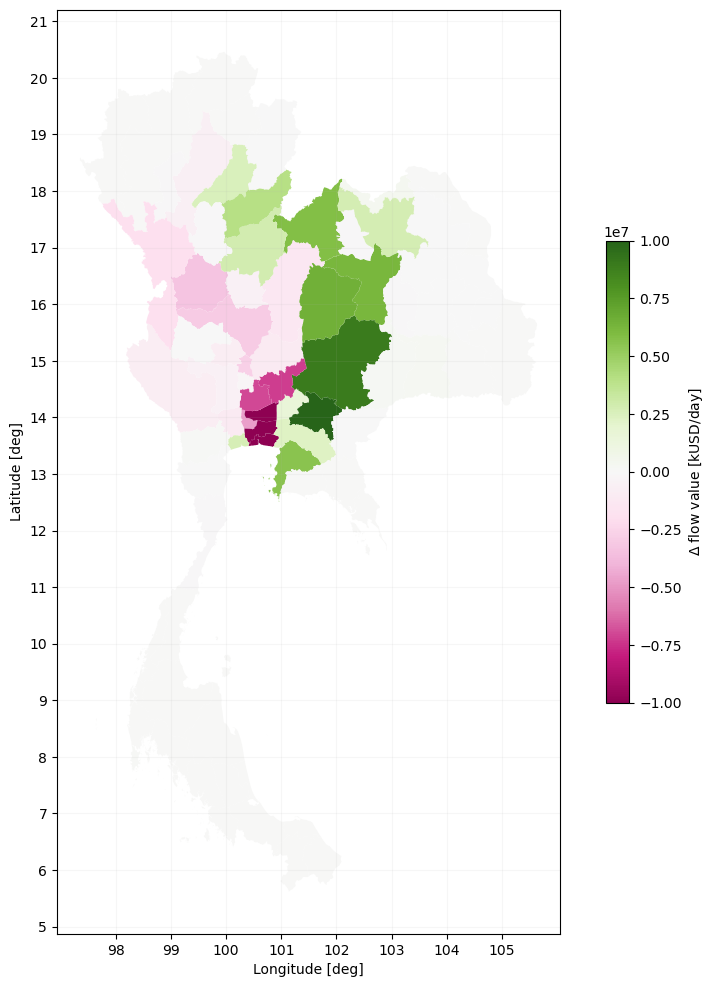

In [108]:
half_width = 1e7
f, ax = get_figure_and_axes()
delta_adm1_g.plot(
    ax=ax,
    column="value_kusd",    
    cmap="PiYG",
    legend=True,
    legend_kwds={"shrink": 0.5, "label": r"$\Delta$ flow value [kUSD/day]"},
    vmin=-half_width,
    vmax=half_width,
)
# zoom(ax)
f.savefig("adm1_delta_value.png")

In [122]:
delta_adm1_g[numpy.abs(delta_adm1_g.value_kusd) > 5e6].sort_values("value_kusd")

,value_kusd,value_kusd_perc,value_kusd_factor,volume_tons,volume_tons_perc,volume_tons_factor,NAME_1,geometry
GID_1,,,,,,,,
THA.3_1,-4.947850e+07,7.441605e+06,9.122105e+04,-2.786531e+07,8.220097e+06,9.900597e+04,Bangkok Metropolis,"POLYGON ((100.58107 13.66721, 100.58132 13.668..."
THA.57_1,-1.335788e+07,1.254869e+06,1.431469e+04,-7.127223e+06,1.351953e+06,1.528553e+04,Samut Prakan,"POLYGON ((100.90887 13.59071, 100.90811 13.588..."
THA.37_1,-1.023706e+07,3.817000e+05,5.710000e+03,-6.079077e+06,1.691929e+05,3.584929e+03,Pathum Thani,"POLYGON ((100.66483 13.92912, 100.64371 13.930..."
THA.60_1,-7.257142e+06,2.223341e+06,2.390141e+04,-5.676103e+06,1.137611e+06,1.304411e+04,Saraburi,"POLYGON ((101.02471 14.30901, 101.02070 14.302..."
THA.46_1,-7.005950e+06,1.555499e+04,2.346550e+03,-4.211200e+06,-1.224882e+05,9.661183e+02,Phra Nakhon Si Ayutthaya,"POLYGON ((100.62193 14.14180, 100.62096 14.140..."
THA.12_1,5.565416e+06,1.972143e+07,2.027303e+05,4.675832e+06,2.471961e+07,2.527121e+05,Chon Buri,"MULTIPOLYGON (((100.97416 12.51938, 100.97430 ..."
THA.21_1,5.840775e+06,3.384464e+08,3.385578e+06,3.203903e+06,1.162373e+08,1.163487e+06,Loei,"POLYGON ((101.11656 16.95100, 101.11701 16.941..."
THA.17_1,6.218677e+06,3.056655e+06,3.348355e+04,6.745303e+06,1.573380e+06,1.865080e+04,Khon Kaen,"POLYGON ((102.41395 15.69667, 102.41095 15.697..."
THA.8_1,6.517006e+06,2.106035e+07,2.122465e+05,4.048513e+06,7.685814e+06,7.850114e+04,Chaiyaphum,"POLYGON ((101.49357 15.35663, 101.48684 15.361..."
